## Proyecto de Clasificación de Imágenes de F1 - Modelo 1: Keras CNN + Transfer Lerning + Fine Tuning

**Autor:** Gerónimo Pautazzo
**Fecha:** 14 de Octubre de 2025

### Objetivo del Notebook

El objetivo de este notebook es construir, entrenar y evaluar un primer modelo de Red Neuronal Convolucional (CNN) utilizando Keras y TensorFlow. Se aplicará la técnica de **Transfer Learning** con el modelo `EfficientNetB0` como base para clasificar imágenes en tres categorías: `crash`, `f1` y `safety_car`.

El proceso incluye:
1.  Carga y preprocesamiento de datos.
2.  Entrenamiento de un modelo base para establecer una línea de rendimiento.
3.  Optimización de hiperparámetros con **Keras Tuner**.
4.  Entrenamiento y evaluación detallada del modelo final optimizado.

In [ ]:
#instalacion de librerias (pip)
#!pip install keras-tuner
#!pip install tensorflow-directml #Para GPUs AMD es una API de Microsoft que permite a los framworks de IA usar cualquier tarjeta que sea compatible con DirectX12
#!pip install numpy matplotlib seaborn scikit-learn tensorflow

In [2]:
#Herramientas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#Keras Tuner
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report

#Modelo Preentrenado
from tensorflow.keras.applications import EfficientNetB0
print("Version de TensorFlow: ", tf.__version__)

Version de TensorFlow:  2.19.0


### Preparación y Exploración de Datos

+ Preparamos nuestro pipeline de datos
+ Definimos los parametros
+ Carga de Datos
+ Data Augmentation
+ Análisis Exploratorio

In [3]:
#Definicion de parametros globales
DATA_DIR = "C:/Users/Urano/OneDrive/Escritorio/RoadMap/Proyectos CV/Clasificacion DL CNN- ViT/datos"
IMAGE_SIZE = (224, 224) #El tamaño de redimension de las images
BATCH_SIZE = 16 # Numero de imagenes que se procesan por cada paso/lote
#EPOCHS = 5 # Numero de veces que el modelo vera el dataset completo
VALIDATION_SPLIT = 0.2 # 20% DE DATOS PARA VALIDACION
SEED = 42 # Semilla de reproducibilidad

In [4]:
#Cargar los datos desde el directorio
train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels = "inferred",
    label_mode = "categorical", # para clasificacion multiclase (genera vectores one-hot).
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True, # Mezclar los datos
    seed = SEED,
    validation_split =VALIDATION_SPLIT,
    subset = "both" # Indica que queremos crear ambos subconjuntos (entrenamiento y validación). 
)

print("¡Datos cargados!")

Found 153 files belonging to 3 classes.
Using 123 files for training.
Using 30 files for validation.
¡Datos cargados!



Clases encontradas: ['crash', 'f1', 'safety_car']
Número de clases: 3

Mostrando un lote de imágenes de entrenamiento...


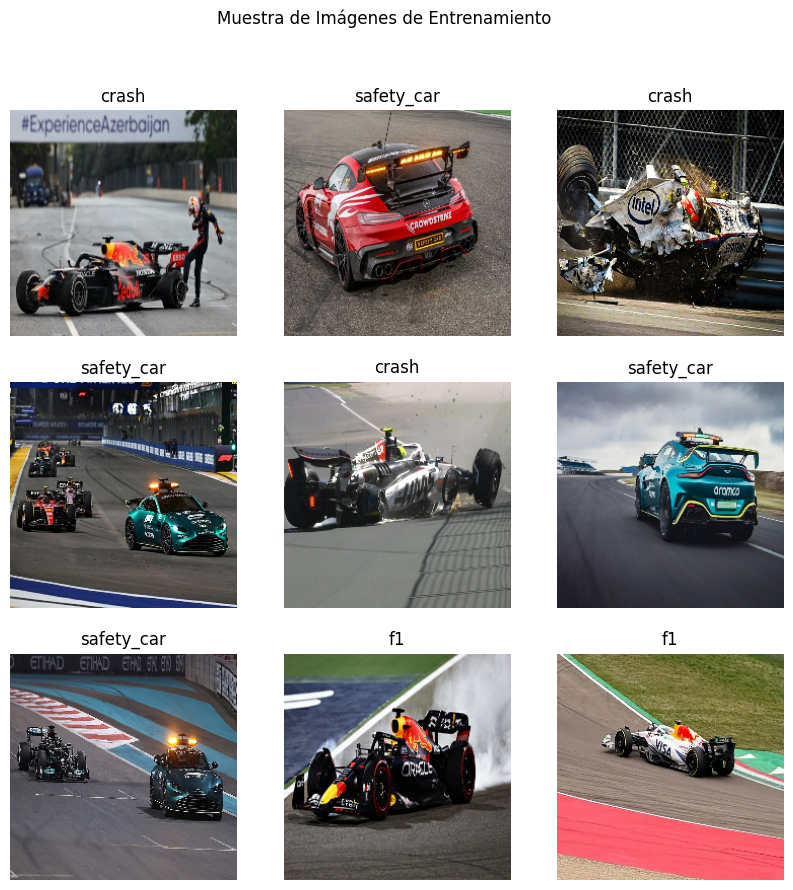

In [5]:
#Verificar los datos 
class_names = train_dataset.class_names
print(f"\nClases encontradas: {class_names}")
print(f"Número de clases: {len(class_names)}")

#Visualiozamos algunas imagenes del primer batch de entrenamiento
print("\nMostrando un lote de imágenes de entrenamiento...")

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): #tomamoas solo el primer batch
    for i in range(9): #Mostramos 9 imagenes 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # El label es un vector one-hot, ej: [0., 1., 0.]. np.argmax nos da el índice del valor máximo (la clase correcta).
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Muestra de Imágenes de Entrenamiento")
plt.show()

In [6]:
# Data Augmentation y Optimizacion

#Definicion de las Capas de Aumentos de Datos 
#pequeño modelo secuencial para aplicar las transformaciones
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    #layers.RandomShear(0.2), # El Shear a veces deforma mucho, es opcional.
    layers.RandomContrast(0.2),
], name="data_augmentation")

#Aplicacion del aumento de datos al conjunto de entrenamiento
train_dataset_final = train_dataset.map(
    lambda image, label: (data_augmentation(image, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

#Optimizacion del rendimineto del Pipeline de datos
# .cache(): Guarda los datos en memoria después de la primera época para no tener que releerlos del disco.
# .prefetch(): Prepara los siguientes lotes de datos mientras el modelo está entrenando con el lote actual.
# Ambas son optimizaciones clave para un entrenamiento rápido.

AUTOTUNE = tf.data.AUTOTUNE
train_dataset_final = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset_final = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("¡Pipeline de datos completado!")
print("Se ha aplicado Data Augmentation al conjunto de entrenamiento.")
print("Ambos datasets (entrenamiento y validación) han sido optimizados con .cache() y .prefetch().")

¡Pipeline de datos completado!
Se ha aplicado Data Augmentation al conjunto de entrenamiento.
Ambos datasets (entrenamiento y validación) han sido optimizados con .cache() y .prefetch().


Mostrando el efecto del Data Augmentation...


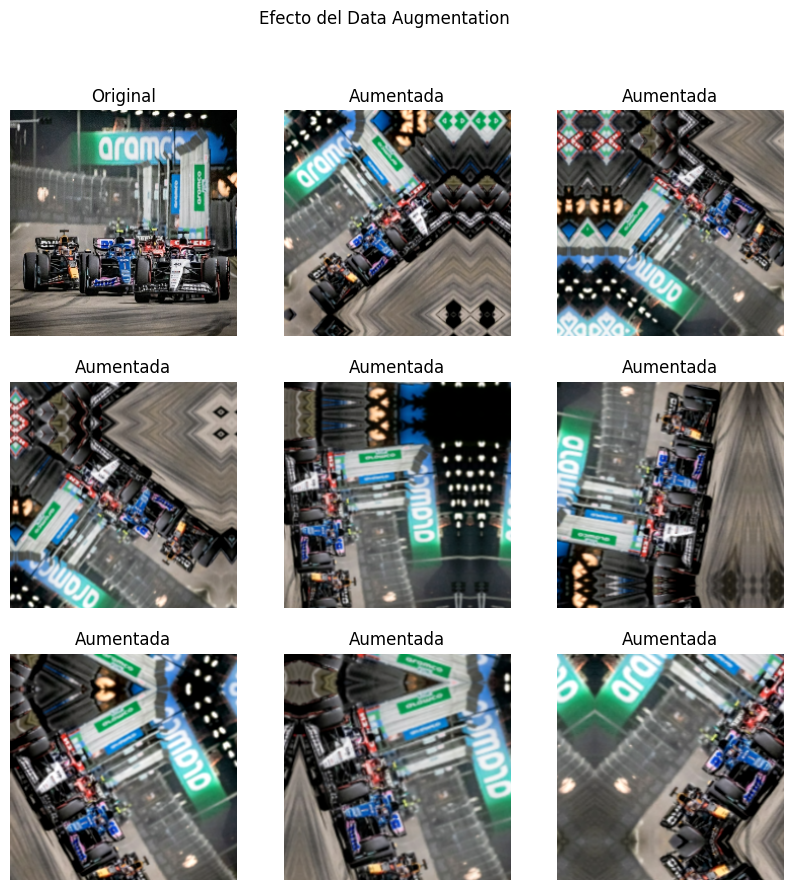

In [7]:
print("Mostrando el efecto del Data Augmentation...")
# Tomamos un batch del dataset ORIGINAL (train_dataset_orig)
for image, label in train_dataset.take(1):
    first_image = image[0]
    plt.figure(figsize=(10, 10))
    
    # Mostramos la imagen original
    plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Mostramos 8 versiones aumentadas
    for i in range(8):
        ax = plt.subplot(3, 3, i + 2)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title("Aumentada")
        plt.axis("off")
        
    plt.suptitle("Efecto del Data Augmentation")
    plt.show()
    break # Solo necesitamos una imagen


In [8]:
#Construcciondel modelo con Transfer Learning

#Definicon del número de clases 
NUM_CLASSES = len(class_names)

#Carga del Modelo Preentrenado
""" Cargamos EfficientNetB0, entrenado en millones de imágenes (ImageNet).
- input_shape: Debe coincidir con el tamaño de nuestras imágenes.
- include_top=False: Excluye la capa final de 1000 clases de ImageNet.
- weights='imagenet': Especifica que queremos los pesos del pre-entrenamiento.""" 

base_model = EfficientNetB0(
    input_shape = IMAGE_SIZE + (3,), # (224, 224, 3)
    include_top = False,
    weights = "imagenet"
)

#Congelear las capas bases
base_model.trainable = False
print(f"El modelo base '{base_model.name}' tiene {len(base_model.layers)} capas y ha sido congelado.")

El modelo base 'efficientnetb0' tiene 238 capas y ha sido congelado.


In [9]:
# Construccion del cabezal de clasificacion
inputs = base_model.input
x = base_model.output
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x) #es como un flatten promediado (cnn reduce cada mapa de características (feature map) a un solo valor, tomando el promedio de todos los valores espaciales (alto × ancho) de ese mapa.)
x = layers.Dropout(0.3, name="top_dropout")(x) # regularizacion
x = layers.Dense(NUM_CLASSES, activation="softmax", name = "output_layer")(x)

#Union del modelo base con el cabezal de clasificacion
model = Model(inputs=inputs, outputs=x)

In [10]:
#Compilacion del modelo

model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = "categorical_crossentropy", # porque es clasificacion multiclase y las etiquetas son one_hot
    metrics = ["accuracy"]
)

print("\n¡Modelo final construido y compilado!")
print("\nResumen del modelo:")
#model.summary()


¡Modelo final construido y compilado!

Resumen del modelo:


In [11]:
print("\nIniciando el entrenamiento inicial...")

# Entrenamos el modelo con los hiperparámetros iniciales por unas épocas
history_base = model.fit(
    train_dataset_final,
    epochs=20, # Entrenamos 20 épocas para ver su comportamiento
    validation_data=validation_dataset_final
)

# Evaluamos este modelo base
print("\n--- Resultados del Modelo Base (Antes de Optimizar) ---")
loss_base, accuracy_base = model.evaluate(validation_dataset_final)
print(f"Precisión en validación (línea base): {accuracy_base * 100:.2f}%")



Iniciando el entrenamiento inicial...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step - accuracy: 0.5422 - loss: 0.8700 - val_accuracy: 0.9333 - val_loss: 0.2643
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.9533 - loss: 0.1708 - val_accuracy: 0.9667 - val_loss: 0.1769
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.9954 - loss: 0.0434 - val_accuracy: 0.9333 - val_loss: 0.1565
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.9932 - loss: 0.0273 - val_accuracy: 0.9333 - val_loss: 0.1200
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.9947 - loss: 0.0219 - val_accuracy: 0.9667 - val_loss: 0.0840
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.9333 - val_loss: 0.1074
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 0.9333 - val_loss: 0.0867
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 1.0000 - loss: 0

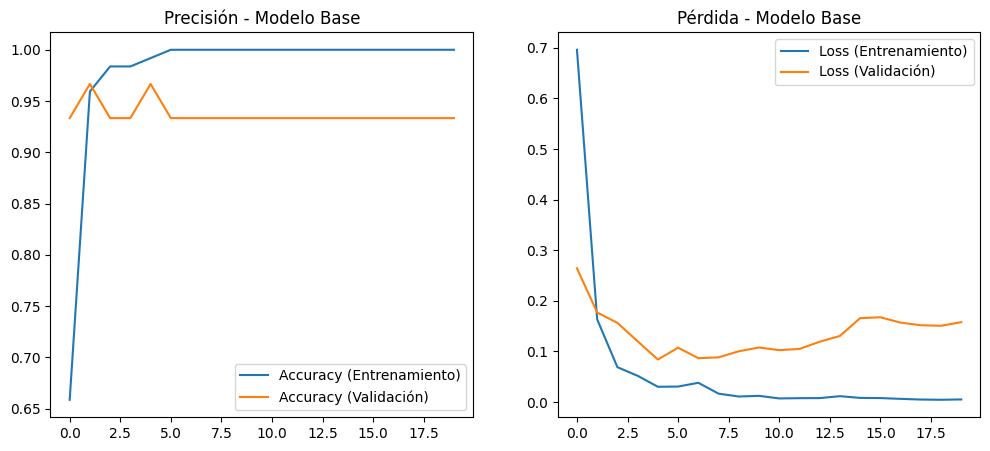

--- Fin del Entrenamiento ---


In [12]:
# Visualizamos las curvas de este entrenamiento inicial
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']
loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy (Entrenamiento)')
plt.plot(epochs_range, val_acc, label='Accuracy (Validación)')
plt.legend()
plt.title('Precisión - Modelo Base')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss (Entrenamiento)')
plt.plot(epochs_range, val_loss, label='Loss (Validación)')
plt.legend()
plt.title('Pérdida - Modelo Base')
plt.show()

print("Fin del Entrenamiento.")

### Optimización de Hiperparámetros con Keras Tuner

Tras establecer una línea base, el siguiente paso es encontrar la mejor combinación de hiperparámetros para nuestro modelo. En lugar de hacerlo manualmente, utilizamos **Keras Tuner**, una herramienta que automatiza este proceso.

Definimos un _"espacio de búsqueda"_ para que el tuner pruebe diferentes valores para:
+ Tasa de Aprendizaje (`learning_rate`)
+ Tasa de Dropout (`dropout`)

In [13]:
#Busqueda de hioperparametros con Keras Tuner

# funcion HyperModel, define el modelo y el espacio de busqueda, llama al objeto hp para probar diferentes valores
# un objeto hp (abreviatura de HyperParameters) es una instancia que representa el espacio de búsqueda de hiperparámetros. 
# Es decir, define qué hiperparámetros se van a explorar, sus rangos o valores posibles, y cómo se seleccionan durante la optimización.

def build_hypermodel(hp):
    #reconstruccion de la arquitectura del modelo
    base_model = EfficientNetB0(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    #Definicion de espacio de busqueda de hiperparametros 

    #HP1 - Tasa de Dropout
    hp_dropout = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)

    #HP2 - Tasa de aprendizaje 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4]) # Choise:  lista cerrada de opciones

    #Cabezal de clasificacion con hiperparametros
    inputs = base_model.input
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp_dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [14]:
# Definicion del tuner
# se usa RanomSearch porque es mas eficiente y efctivo
tuner = kt.RandomSearch(
    build_hypermodel,
    objective = "val_accuracy", #metrica a maximizar
    max_trials = 5, #cantidad de combinaciones a probar 
    # executions_pre_trial=1, # entrenar cada combinacion 1 vez(funciona en verciones anteriores de keras tuner)
    directory = "keras_tuner_dir",
    project_name = "f1_classification"
    )


#resumen del espacio de busqueda 
tuner.search_space_summary()

print("\nIniciando la búsqueda de los mejores hiperparámetros...")
tuner.search(
    train_dataset_final,
    epochs=10, 
    validation_data=validation_dataset_final
)
print("Busqueda Finalizada.")
#Mejores Resultados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
--------------------------------------------------
¡Búsqueda de hiperparámetros completada!

Los mejores valores encontrados son:
- Tasa de Dropout: {best_hps.get('dropout'):.2f}
- Tasa de Aprendizaje: {best_hps.get('learning_rate')}
--------------------------------------------------
""")

Reloading Tuner from keras_tuner_dir\f1_classification\tuner0.json
Search space summary
Default search space size: 2
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Iniciando la búsqueda de los mejores hiperparámetros...
Busqueda Finalizada.

--------------------------------------------------
¡Búsqueda de hiperparámetros completada!

Los mejores valores encontrados son:
- Tasa de Dropout: 0.20
- Tasa de Aprendizaje: 0.001
--------------------------------------------------



In [15]:
# Entrenamiento de Modelo final con hiperparametros optimos y evaluacion
final_model = tuner.hypermodel.build(best_hps)

print("\n Modelo final construido con hiperparametros optimos.")
final_model.summary()


 Modelo final construido con hiperparametros optimos.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
#Definicion de callbacks de entrenamiento 
# EarlyStopping detendrá el entrenamiento si la 'val_loss' no mejora

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5, # Espera 5 épocas sin mejora antes de parar.
    verbose= 1,
    restore_best_weights = True
)

#Entrenamiento del modelo final
print("\nIniciando el entrenamiento final...")
history = final_model.fit(
    train_dataset_final,
    epochs =30,
    validation_data = validation_dataset_final,
    callbacks = [early_stopping]
)


Iniciando el entrenamiento final...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 725ms/step - accuracy: 0.2397 - loss: 1.3439 - val_accuracy: 0.4333 - val_loss: 0.9841
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.6840 - loss: 0.8383 - val_accuracy: 0.8667 - val_loss: 0.7729
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.8416 - loss: 0.6181 - val_accuracy: 0.8667 - val_loss: 0.6170
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.8443 - loss: 0.4875 - val_accuracy: 0.9000 - val_loss: 0.5142
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9228 - loss: 0.4068 - val_accuracy: 0.9000 - val_loss: 0.4428
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9662 - loss: 0.3101 - val_accuracy: 0.9000 - val_loss: 0.3967
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.9489 - loss: 0.2898 - val_accuracy: 0.9333 - val_loss: 0.3617
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.9540 - loss: 0.2

In [17]:
# Evaluacion del modelo con el conjunto de evaluacion

loss, accuracy = final_model.evaluate(validation_dataset_final)
print(f"\nPrecisión final en el conjunto de validación: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9139 - loss: 0.1891

Precisión final en el conjunto de validación: 93.33%


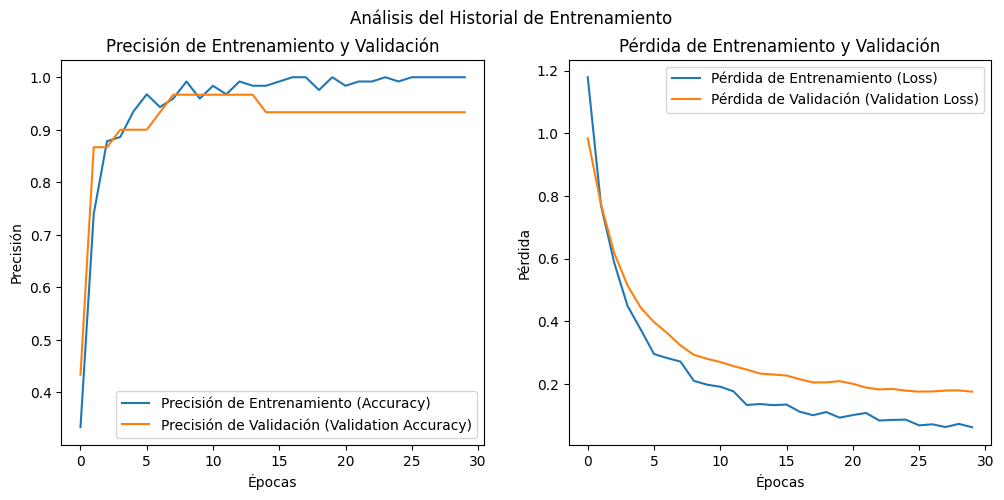

In [18]:
# Visualizacion de la curva de entrenamiento
#history contiene datos de perdida y precision por epoca

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento (Accuracy)')
plt.plot(epochs_range, val_acc, label='Precisión de Validación (Validation Accuracy)')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento (Loss)')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación (Validation Loss)')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')

plt.suptitle('Análisis del Historial de Entrenamiento')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


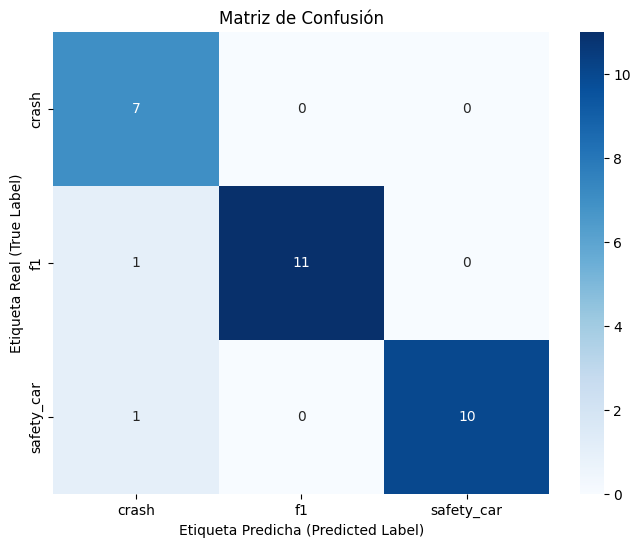


             REPORTE DETALLADO DE CLASIFICACIÓN
              precision    recall  f1-score   support

       crash       0.78      1.00      0.88         7
          f1       1.00      0.92      0.96        12
  safety_car       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.95      0.93      0.94        30



In [19]:
# Analisis de rendimiento

#predicciones y etiquetas reales 
y_pred = []
y_true = []

#iteramos sobre la validacion
for images, labels, in validation_dataset_final:
    preds = final_model.predict(images) #hacemos predicciones para el lote actual
    # Convertimos las predicciones (probabilidades) y etiquetas (one-hot) a etiquetas de clase (0, 1, 2)
    y_pred.extend(np.argmax(preds, axis=1)) #indice de la clase con mayor probabilidad
    y_true.extend(np.argmax(labels.numpy(), axis=1)) 

#matriz de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha (Predicted Label)')
plt.ylabel('Etiqueta Real (True Label)')
plt.title('Matriz de Confusión')
plt.show()


#Reporte de clasificacion (presicion, recall, f1-score por clase)
print("\n" + "="*60)
print("             REPORTE DETALLADO DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)



In [20]:
# Guardamos el modelo final en un único archivo HDF5.
# Este archivo contiene todo:
# - La arquitectura del modelo.
# - Los pesos entrenados.
# - La configuración de la compilación (optimizador, pérdida).
model_filename = 'f1_classifier_keras_cnn.h5'
final_model.save(model_filename)

print(f"\nModelo final guardado exitosamente en el archivo: '{model_filename}'")



Modelo final guardado exitosamente en el archivo: 'f1_classifier_keras_cnn.h5'


## Conclusión del Notebook

El proceso de optimización fue un éxito. El modelo final, utilizando los hiperparámetros encontrados por Keras Tuner, alcanzó una precisión del **93%** en el conjunto de validación. El análisis detallado muestra un rendimiento robusto en todas las clases, validando la eficacia del Transfer Learning con `EfficientNetB0` para este problema. El modelo ha sido guardado en el archivo `f1_classifier_keras_cnn.h5` para su uso y comparación en fases posteriores del proyecto.